## Steps

1. Collect your data, taking into account:
   - occlusion, illumination, viewpoint variation, scale variation, deformation and background
2. Choose the format you'll save (XML or JSON)
   - Pascal or COCO


## Kinds of data structures

- Pascal: use xml format
- COCO: use json format


In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, PSDraw


In [2]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [3]:
path_train_data = "./data/obj_detection/archive/train/"
path_test_data = "./data/obj_detection/archive/test/"
files_xml_annotation = glob.glob(path_train_data + "*.xml")


In [4]:
tree = ET.parse(files_xml_annotation[0])
root = tree.getroot()
member = root.findall("object")

member[0].find("bndbox").find("xmin").text


'97'

In [5]:
xml_list = []
for file in files_xml_annotation:
    tree = ET.parse(file)
    root = tree.getroot()
    for member in root.findall("object"):
        value = (
            root.find("filename").text,
            int(root.find("size").find("width").text),
            int(root.find("size").find("height").text),
            member.find("name").text,
            int(member.find("bndbox").find("xmin").text),
            int(member.find("bndbox").find("ymin").text),
            int(member.find("bndbox").find("xmax").text),
            int(member.find("bndbox").find("ymax").text),
        )
        xml_list.append(value)
columns = ["filename", "width", "height", "class", "xmin", "ymin", "xmax", "ymax"]
xml_df = pd.DataFrame(xml_list, columns=columns)


In [6]:
set(xml_df["class"].to_list())


{'apple', 'banana', 'orange'}

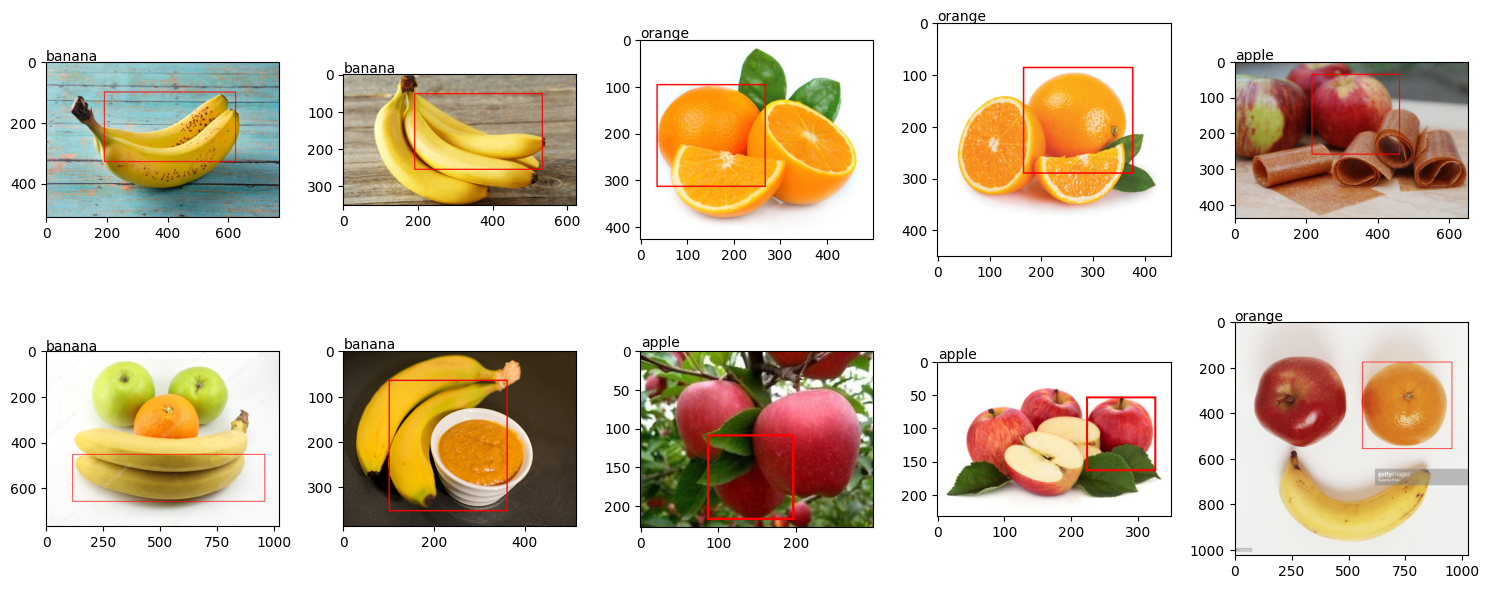

In [7]:
imgs = []
labels = []
for i, row in xml_df.sample(10).iterrows():
    path_file_name = path_train_data + row.filename
    img = Image.open(path_file_name)
    draw = ImageDraw.Draw(img)
    draw.rectangle(
        xy=((row.xmin, row.ymin), (row.xmax, row.ymax)), outline="red", width=3
    )
    imgs.append(img)
    labels.append(row[3])

plt.figure(figsize=(15, 15))
for i, img in enumerate(imgs, start=1):
    plt.subplot(5, 5, i)
    plt.imshow(img)
    plt.text(0, -5, labels[i - 1])

plt.tight_layout()
plt.show()


## Creating a Dataset class

In [8]:
from torch.utils.data import Dataset, DataLoader
import cv2
import numpy as np
import torch
from config.config import CLASSES, RESIZE_TO, TRAIN_DIR, VALID_DIR, BATCH_SIZE

In [9]:
class FruitDataset(Dataset):
    def __init__(
        self, dir_path: str, width: int, height: int, classes: str, transforms=None
    ) -> None:
        super().__init__()
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes

        # get all the images paths in sorted order
        self.image_paths = glob.glob(dir_path + "*.jpg")
        self.all_images = [image_path.split("/")[-1] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)

    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name)
        # read the image
        image = cv2.imread(image_path)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0  # why?

        # capture the corresponding XML file for getting the annotations
        annot_filename = image_name[:-4] + ".xml"
        annot_file_path = os.path.join(self.dir_path, annot_filename)

        boxes = []
        labels = []
        tree = ET.parse(annot_file_path)
        root = tree.getroot()

        # get the height and width of the image
        width = image.shape[1]
        height = image.shape[0]

        # box coordinates for xml files are extracted and corrected
        # for image size given
        for member in root.findall("object"):
            ## map the current object name to 'classes' list to get
            ## the label index and append to 'labels' list
            labels.append(self.classes.index(member.find("name").text))
            ## xmin, xmax, ymin, ymax
            xmin = int(member.find("bndbox").find("xmin").text)
            xmax = int(member.find("bndbox").find("xmax").text)
            ymin = int(member.find("bndbox").find("ymin").text)
            ymax = int(member.find("bndbox").find("ymax").text)

            ## update those coordinates
            xmin_final = (xmin / width) * self.width
            xmax_final = (xmax / width) * self.width
            ymin_final = (ymin / height) * self.height
            ymax_final = (ymax / height) * self.height

            boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

        # bounding box to tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        # area of the bounding boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # no crowd instances
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        # labels to tensor
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # prepare the final target dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        # apply image transforms
        if self.transforms:
            sample = self.transforms(
                image=image_resized, bboxes=target["boxes"], labels=labels
            )
            image_resized = sample["image"]
            target["boxes"] = torch.Tensor(sample["bboxes"])

        return image_resized, target

    def __len__(self):
        return len(self.all_images)


In [40]:
def get_train_transform():
    train_transform = A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        # ToTensorV2(p=1.0)
    ],
    bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    }
    )
    return train_transform

def get_test_transform():
    test_transform = A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    return test_transform

In [28]:
def collate_fn(batch):
    # To handle the data loading as different images may have different number 
    # of objects and to handle varying size tensors as well.
    return tuple(zip(*batch))

In [29]:
train_dataset = FruitDataset(dir_path=path_train_data, width=RESIZE_TO, height=RESIZE_TO, classes=CLASSES, transforms=get_train_transform())
test_dataset = FruitDataset(dir_path=path_test_data, width=RESIZE_TO, height=RESIZE_TO, classes=CLASSES, transforms=get_test_transform())
train_validator = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, collate_fn=collate_fn)
test_validator = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, collate_fn=collate_fn)
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of testing samples: {len(test_dataset)}')

Number of training samples: 240
Number of testing samples: 60


In [ ]:
boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])

# bounding box to tensor
boxes = torch.as_tensor(boxes, dtype=torch.float32)

In [41]:
def local_transform_test():
    train_transform = A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
    ],
    )
    return train_transform

transformers = get_train_transform()
transformers

Compose([
  Flip(always_apply=0.5, p=0.5),
  RandomRotate90(always_apply=0.5, p=0.5),
  MotionBlur(always_apply=False, p=0.2, blur_limit=(3, 7)),
  MedianBlur(always_apply=False, p=0.1, blur_limit=(3, 3)),
  Blur(always_apply=False, p=0.1, blur_limit=(3, 3)),
], p=1.0, bbox_params={'format': 'pascal_voc', 'label_fields': ['labels'], 'min_area': 0.0, 'min_visibility': 0.0, 'check_each_transform': True}, keypoint_params=None, additional_targets={})

In [42]:
imgs = []
labels = []
for i, row in xml_df.sample(10).iterrows():
    path_file_name = path_train_data + row.filename
    img = Image.open(path_file_name)
    img_np = np.array(img)
    print(img_np.shape)
    box = [row.xmin, row.ymin, row.xmax, row.ymax]
    img_np_transformed = transformers(image=img_np, bboxes=box, labels=row[3])
    # draw = ImageDraw.Draw(img)
    # draw.rectangle(
    #     xy=((row.xmin, row.ymin), (row.xmax, row.ymax)), outline="red", width=3
    # )
    imgs.append(img_np_transformed["image"])
    # labels.append(row[3])

plt.figure(figsize=(15, 15))
for i, img in enumerate(imgs, start=1):
    plt.subplot(5, 5, i)
    plt.imshow(img)
    # plt.text(0, -5, labels[i - 1])

plt.tight_layout()
plt.show()

(423, 630, 3)


TypeError: object of type 'int' has no len()

In [32]:
cv2.imwrite("test.png", img_np_transformed)

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - img is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'img'


TypeError: Invalid shape (3, 512, 512) for image data

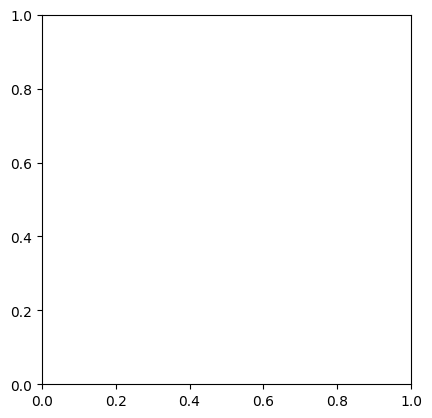

In [13]:
image, target = train_dataset[220]
plt.imshow(image)
target

# def visualize_image(image: np.array, target: dict):
#     box = target.get("boxes")[0]
#     print(target.get('labels'))
#     label = CLASSES[target.get("labels")]
#     cv2.rectangle(
#         image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 1
#     )
#     cv2.putText(
#         image,
#         label,
#         (int(box[0]), int(box[1] - 5)),
#         cv2.FONT_HERSHEY_SIMPLEX,
#         0.7,
#         (0, 0, 255),
#         2,
#     )
#     cv2.imshow("Image", image)
#     cv2.waitKey(0)


def visualize_image(NUM_SAMPLES_TO_VISUALIZE: int):
    # ...
    labels = []
    imgs = []
    # for i, row in xml_df.sample(10).iterrows():
    #     path_file_name = path_train_data + row.filename
    for i in range(NUM_SAMPLES_TO_VISUALIZE):
        img, target = train_dataset[np.random.randint(low=0, high=241)]
        img = (img * 255).astype(np.uint8)
        pil_img = Image.fromarray(img)
        draw = ImageDraw.Draw(pil_img)
        internal_label = []
        for i, boxe in enumerate(target["boxes"]):
            draw.rectangle(
                xy=(
                    (target["boxes"][i][0], target["boxes"][i][1]),
                    (target["boxes"][i][2], target["boxes"][i][3]),
                ),
                outline="red",
                width=4,
            )
            label = CLASSES[target["labels"][i]]
            internal_label.append(label)
        imgs.append(pil_img)
        labels.append(internal_label)
    
    plt.figure(figsize=(15, 15))
    for i, pil_img_drawed in enumerate(imgs, start=1):
        plt.subplot(5, 5, i)
        plt.imshow(pil_img_drawed)
        plt.text(0, -5, labels[i - 1])

    plt.tight_layout()


plt.show()

NUM_SAMPLES_TO_VISUALIZE = 5
# for i in range(NUM_SAMPLES_TO_VISUALIZE):
#     image, target = train_dataset[i]
visualize_image(NUM_SAMPLES_TO_VISUALIZE)


In [17]:
%load_ext watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [15]:
%watermark --iversions

sys       : 3.10.0 (default, Feb 12 2022, 05:54:17) [GCC 9.3.0]
torch     : 1.11.0+cu113
matplotlib: 3.5.3
pandas    : 1.4.3
cv2       : 4.6.0
PIL       : 9.2.0
numpy     : 1.23.2

